## Author:
## Mohammed Fawaz Nawaz
## Matrikulation No.: 7431597
## ESDP1 HOMEWORK2 WS 2025/26

In [23]:
# STEP 1: Create a fresh project folder structure (Windows/Linux/Mac safe)
 
from pathlib import Path
 
# Create a new folder next to your notebook (or inside the current working directory)
PROJECT_ROOT = Path.cwd() / "esdp1_hw2_clean"
 
# Folder structure needed for the homework
folders = [
    PROJECT_ROOT / "src",                 # Python modules (pipeline, downloader, regridding, zarr)
    PROJECT_ROOT / "data" / "tmp",        # temporary downloaded daily files
    PROJECT_ROOT / "data" / "status",     # "done markers" so pipeline can resume
    PROJECT_ROOT / "data" / "zarr",       # final zarr stores
    PROJECT_ROOT / "plots",               # output plots (png)
]
 
# Create all folders (does nothing if already exists)
for f in folders:
    f.mkdir(parents=True, exist_ok=True)
 
print("✅ Created project at:", PROJECT_ROOT)
print("✅ Folders created:")


✅ Created project at: C:\Users\User\esdp1_hw2\esdp1_hw2_clean
✅ Folders created:


In [25]:
for f in folders:
    print("  -", f.relative_to(PROJECT_ROOT))

  - src
  - data\tmp
  - data\status
  - data\zarr
  - plots


In [27]:
# STEP 2: Create src/pipeline.py (mock daily control flow)
 
from pathlib import Path
 
PROJECT_ROOT = Path.cwd() / "esdp1_hw2_clean"
src_dir = PROJECT_ROOT / "src"
src_dir.mkdir(parents=True, exist_ok=True)
 
pipeline_code = r'''
"""
pipeline.py
 
Mock daily processing pipeline (Homework #2 - control flow requirement).
 
What this file provides:
- Run with no arguments:
    -> find the oldest missing day and process forward day-by-day.
- Run with a date argument YYYY-MM-DD:
    -> process only that specific day.
- Uses a ".done" marker file per day in data/status/ to support restart/resume.
 
In this step we do NOT download ERA5 yet.
We simulate "download + processing" so you can test success/failure behavior.
"""
 
from __future__ import annotations
 
import sys
import random
from datetime import datetime, date, timedelta
from pathlib import Path
 
 
# -----------------------------
# Settings for the mock test
# (We keep them here temporarily to stay simple.
#  Later we will move them into src/config.py.)
# -----------------------------
START_DATE = "2024-12-01"
END_DATE   = "2024-12-05"
 
# Chance that a "download" fails in mock mode.
# This is only for testing workflow behavior.
MOCK_FAIL_PROB = 0.30
 
 
# -----------------------------
# Helper functions for dates
# -----------------------------
def parse_day(day_str: str) -> date:
    """Convert 'YYYY-MM-DD' string to a date object."""
    return datetime.strptime(day_str, "%Y-%m-%d").date()
 
 
def day_to_str(d: date) -> str:
    """Convert a date object to 'YYYY-MM-DD' string."""
    return d.strftime("%Y-%m-%d")
 
 
def daterange(start: date, end_inclusive: date):
    """Yield dates from start to end_inclusive (including end_inclusive)."""
    cur = start
    while cur <= end_inclusive:
        yield cur
        cur += timedelta(days=1)
 
 
# -----------------------------
# Resume logic using done markers
# -----------------------------
def status_dir() -> Path:
    """Return the folder where .done marker files are stored."""
    return Path("data/status")
 
 
def done_marker_path(day: str) -> Path:
    """Return the path for the .done file of a given day."""
    return status_dir() / f"{day}.done"
 
 
def is_done(day: str) -> bool:
    """Check if a day was already processed (marker file exists)."""
    return done_marker_path(day).exists()
 
 
def mark_done(day: str) -> None:
    """Create the .done marker file for the day."""
    status_dir().mkdir(parents=True, exist_ok=True)
    done_marker_path(day).write_text("ok\n", encoding="utf-8")
 
 
def find_oldest_missing_day(start: date, end_inclusive: date) -> date | None:
    """
    Find the oldest date in [start, end_inclusive] that is NOT marked done.
    Returns None if all days are done.
    """
    for d in daterange(start, end_inclusive):
        if not is_done(day_to_str(d)):
            return d
    return None
 
 
# -----------------------------
# Mock "download + processing"
# -----------------------------
def mock_download(day: str) -> Path:
    """
    Simulate a download step:
    - sometimes fails (random)
    - otherwise creates a tiny temp file in data/tmp/
    """
    tmp_dir = Path("data/tmp")
    tmp_dir.mkdir(parents=True, exist_ok=True)
 
    # Simulate failure
    if random.random() < MOCK_FAIL_PROB:
        raise RuntimeError(f"Mock download failed for {day}")
 
    out_path = tmp_dir / f"{day}.mock.txt"
    out_path.write_text(f"mock data for {day}\n", encoding="utf-8")
    return out_path
 
 
def process_one_day(d: date) -> None:
    """
    Process one day:
    1) mock download
    2) mock processing
    3) mark done
    """
    day = day_to_str(d)
    print(f"\n=== Processing {day} ===")
 
    # 1) Download (mock)
    try:
        fpath = mock_download(day)
        print("Download OK ->", fpath)
    except Exception as e:
        # Important: If download fails, we do NOT mark done.
        # This allows retry later.
        print("Download FAILED ->", e)
        return
 
    # 2) Mock processing (placeholder for regridding + zarr later)
    _ = fpath.read_text(encoding="utf-8")
    print("Mock processing OK")
 
    # 3) Mark done (so the pipeline can resume later)
    mark_done(day)
    print("Marked done ->", done_marker_path(day))
 
 
# -----------------------------
# Main CLI entry point
# -----------------------------
def main(argv: list[str]) -> int:
    """
    Usage:
      python -m src.pipeline
        -> process oldest missing day forward until END_DATE
 
      python -m src.pipeline YYYY-MM-DD
        -> process only that date
    """
    start = parse_day(START_DATE)
    end = parse_day(END_DATE)
 
    # Case A: date argument provided
    if len(argv) == 1:
        d = parse_day(argv[0])
        process_one_day(d)
        return 0
 
    # Case B: no args -> process oldest missing forward
    if len(argv) == 0:
        missing = find_oldest_missing_day(start, end)
        if missing is None:
            print("All days are already processed (nothing to do).")
            return 0
 
        for d in daterange(missing, end):
            if is_done(day_to_str(d)):
                continue
            process_one_day(d)
        return 0
 
    # Anything else: print help
    print(main.__doc__)
    return 2
 
 
if __name__ == "__main__":
    raise SystemExit(main(sys.argv[1:]))
'''
 
# Write the file
pipeline_path = src_dir / "pipeline.py"
pipeline_path.write_text(pipeline_code, encoding="utf-8")
 
# Make src a Python package
init_path = src_dir / "__init__.py"
init_path.write_text("", encoding="utf-8")
 
print("✅ Written:", pipeline_path)
print("✅ Written:", init_path)

✅ Written: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\pipeline.py
✅ Written: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\__init__.py


In [29]:
import os
from pathlib import Path
 
PROJECT_ROOT = Path.cwd() / "esdp1_hw2_clean"
os.chdir(PROJECT_ROOT)
 
!python -m src.pipeline


=== Processing 2024-12-01 ===
Download OK -> data\tmp\2024-12-01.mock.txt
Mock processing OK
Marked done -> data\status\2024-12-01.done

=== Processing 2024-12-02 ===
Download OK -> data\tmp\2024-12-02.mock.txt
Mock processing OK
Marked done -> data\status\2024-12-02.done

=== Processing 2024-12-03 ===
Download OK -> data\tmp\2024-12-03.mock.txt
Mock processing OK
Marked done -> data\status\2024-12-03.done

=== Processing 2024-12-04 ===
Download OK -> data\tmp\2024-12-04.mock.txt
Mock processing OK
Marked done -> data\status\2024-12-04.done

=== Processing 2024-12-05 ===
Download FAILED -> Mock download failed for 2024-12-05


In [31]:
# STEP 3: Re-run pipeline with no args
# Expected: it will only attempt the oldest missing day (2024-12-05)
 
!python -m src.pipeline


=== Processing 2024-12-05 ===
Download OK -> data\tmp\2024-12-05.mock.txt
Mock processing OK
Marked done -> data\status\2024-12-05.done


In [35]:
# STEP 4A: robust project root detection (prevents double-folder bugs)
 
from pathlib import Path
import os
 
def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(10):
        if (cur / "src" / "pipeline.py").exists():
            return cur
        cur = cur.parent
    raise FileNotFoundError("Could not find project root containing src/pipeline.py")
 
PROJECT_ROOT = find_project_root(Path.cwd())
print("✅ Detected PROJECT_ROOT:", PROJECT_ROOT)
 
os.chdir(PROJECT_ROOT)
print("📂 Working directory set to:", Path.cwd())

✅ Detected PROJECT_ROOT: C:\Users\User\esdp1_hw2\esdp1_hw2_clean
📂 Working directory set to: C:\Users\User\esdp1_hw2\esdp1_hw2_clean


In [39]:
# STEP 4B: Create src/config.py (no path duplication)
 
from pathlib import Path
 
config_path = Path("src/config.py")
 
config_code = r'''
"""
config.py
 
Central place for user-configurable settings.
Keeping settings here makes the pipeline easy to change and grade-friendly.
"""
 
from dataclasses import dataclass
 
 
@dataclass(frozen=True)
class Settings:
    # Date range for the homework (daily workflow)
    start_date: str = "2024-12-01"
    end_date: str = "2024-12-05"
 
    # Mock settings (used only for workflow testing)
    mock_fail_prob: float = 0.30
'''
 
config_path.write_text(config_code, encoding="utf-8")
print("✅ Written:", config_path.resolve())

✅ Written: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\config.py


In [41]:
# STEP 5: Rewrite src/pipeline.py to use Settings() from src/config.py
 
from pathlib import Path
 
pipeline_path = Path("src/pipeline.py")
 
pipeline_code = r'''
"""
pipeline.py
 
Mock daily processing pipeline (Homework #2 - control flow requirement).
 
This script supports:
- Run with no arguments:
    -> find the oldest missing day and process forward day-by-day.
- Run with a date argument YYYY-MM-DD:
    -> process only that specific day.
- Uses a ".done" marker file per day in data/status/ to support restart/resume.
 
In this stage we still do MOCK processing (no ERA5 download yet).
Later we will replace the mock download with real ERA5 download.
"""
 
from __future__ import annotations
 
import sys
import random
from datetime import datetime, date, timedelta
from pathlib import Path
 
from .config import Settings
 
 
# -----------------------------
# Helper functions for dates
# -----------------------------
def parse_day(day_str: str) -> date:
    """Convert 'YYYY-MM-DD' string to a date object."""
    return datetime.strptime(day_str, "%Y-%m-%d").date()
 
 
def day_to_str(d: date) -> str:
    """Convert a date object to 'YYYY-MM-DD' string."""
    return d.strftime("%Y-%m-%d")
 
 
def daterange(start: date, end_inclusive: date):
    """Yield dates from start to end_inclusive (including end_inclusive)."""
    cur = start
    while cur <= end_inclusive:
        yield cur
        cur += timedelta(days=1)
 
 
# -----------------------------
# Resume logic using done markers
# -----------------------------
def status_dir() -> Path:
    """Folder where .done marker files are stored."""
    return Path("data/status")
 
 
def done_marker_path(day: str) -> Path:
    """Path of the .done marker file for a given day."""
    return status_dir() / f"{day}.done"
 
 
def is_done(day: str) -> bool:
    """Return True if day is already processed (marker exists)."""
    return done_marker_path(day).exists()
 
 
def mark_done(day: str) -> None:
    """Create a .done marker file for the day."""
    status_dir().mkdir(parents=True, exist_ok=True)
    done_marker_path(day).write_text("ok\n", encoding="utf-8")
 
 
def find_oldest_missing_day(start: date, end_inclusive: date) -> date | None:
    """
    Find the oldest date in [start, end_inclusive] that is NOT marked done.
    Returns None if all days are done.
    """
    for d in daterange(start, end_inclusive):
        if not is_done(day_to_str(d)):
            return d
    return None
 
 
# -----------------------------
# Mock "download + processing"
# -----------------------------
def mock_download(day: str, fail_prob: float) -> Path:
    """
    Simulate a download step:
    - sometimes fails (random)
    - otherwise creates a tiny temp file in data/tmp/
    """
    tmp_dir = Path("data/tmp")
    tmp_dir.mkdir(parents=True, exist_ok=True)
 
    # Random failure for testing the pipeline robustness
    if random.random() < fail_prob:
        raise RuntimeError(f"Mock download failed for {day}")
 
    out_path = tmp_dir / f"{day}.mock.txt"
    out_path.write_text(f"mock data for {day}\n", encoding="utf-8")
    return out_path
 
 
def process_one_day(d: date, settings: Settings) -> None:
    """
    Process one day:
    1) mock download
    2) mock processing
    3) mark done
    """
    day = day_to_str(d)
    print(f"\n=== Processing {day} ===")
 
    # 1) Download (mock)
    try:
        fpath = mock_download(day, fail_prob=settings.mock_fail_prob)
        print("Download OK ->", fpath)
    except Exception as e:
        # Important: If download fails, we do NOT mark done.
        # This allows the pipeline to retry later.
        print("Download FAILED ->", e)
        return
 
    # 2) Mock processing placeholder
    _ = fpath.read_text(encoding="utf-8")
    print("Mock processing OK")
 
    # 3) Mark done (so pipeline can resume later)
    mark_done(day)
    print("Marked done ->", done_marker_path(day))
 
 
# -----------------------------
# Main CLI entry point
# -----------------------------
def main(argv: list[str]) -> int:
    """
    Usage:
      python -m src.pipeline
        -> process oldest missing day forward until end_date
 
      python -m src.pipeline YYYY-MM-DD
        -> process only that date
    """
    settings = Settings()
 
    start = parse_day(settings.start_date)
    end = parse_day(settings.end_date)
 
    # Case A: date argument provided
    if len(argv) == 1:
        d = parse_day(argv[0])
        process_one_day(d, settings)
        return 0
 
    # Case B: no args -> process oldest missing forward
    if len(argv) == 0:
        missing = find_oldest_missing_day(start, end)
        if missing is None:
            print("All days are already processed (nothing to do).")
            return 0
 
        for d in daterange(missing, end):
            if is_done(day_to_str(d)):
                continue
            process_one_day(d, settings)
        return 0
 
    # Anything else: print help
    print(main.__doc__)
    return 2
 
 
if __name__ == "__main__":
    raise SystemExit(main(sys.argv[1:]))
'''
 
pipeline_path.write_text(pipeline_code, encoding="utf-8")
print("✅ Updated:", pipeline_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\pipeline.py


In [43]:
!python -m src.pipeline

All days are already processed (nothing to do).


In [45]:
# STEP 6: Delete one done marker and rerun to prove resume logic works
 
from pathlib import Path
 
# Pick one day to "unprocess"
marker = Path("data/status/2024-12-03.done")
 
if marker.exists():
    marker.unlink()
    print("✅ Deleted:", marker)
else:
    print("Marker already missing:", marker)
 
# Now run again: it should process only the missing day(s)
!python -m src.pipeline

✅ Deleted: data\status\2024-12-03.done

=== Processing 2024-12-03 ===
Download OK -> data\tmp\2024-12-03.mock.txt
Mock processing OK
Marked done -> data\status\2024-12-03.done


In [47]:
# STEP 7A: Update src/config.py to include a use_mock switch
 
from pathlib import Path
 
config_path = Path("src/config.py")
text = config_path.read_text(encoding="utf-8")
 
# Simple rewrite (small file, easiest is to overwrite cleanly)
new_config = r'''
"""
config.py
 
Central place for user-configurable settings.
"""
 
from dataclasses import dataclass
 
 
@dataclass(frozen=True)
class Settings:
    # Date range for the homework (daily workflow)
    start_date: str = "2024-12-01"
    end_date: str = "2024-12-05"
 
    # Switch between mock workflow testing and real ERA5 download
    # True  -> use mock "downloads" (no internet, random failures for testing)
    # False -> use real ERA5 downloads (we will implement next)
    use_mock: bool = True
 
    # Mock settings (used only if use_mock=True)
    mock_fail_prob: float = 0.30
'''
 
config_path.write_text(new_config, encoding="utf-8")
print("✅ Updated:", config_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\config.py


In [49]:
# STEP 7B: Update pipeline.py to respect settings.use_mock
 
from pathlib import Path
 
pipeline_path = Path("src/pipeline.py")
 
pipeline_code = r'''
"""
pipeline.py
 
Daily processing pipeline (Homework #2 - control flow requirement).
 
Features:
- Run with no arguments:
    -> find the oldest missing day and process forward day-by-day.
- Run with a date argument YYYY-MM-DD:
    -> process only that specific day.
- Uses a ".done" marker file per day in data/status/ to support restart/resume.
 
This file controls the workflow.
The download routine is chosen via Settings.use_mock:
- use_mock=True  -> mock download (for testing)
- use_mock=False -> real ERA5 download (will be implemented next)
"""
 
from __future__ import annotations
 
import sys
import random
from datetime import datetime, date, timedelta
from pathlib import Path
 
from .config import Settings
 
 
# -----------------------------
# Helper functions for dates
# -----------------------------
def parse_day(day_str: str) -> date:
    """Convert 'YYYY-MM-DD' string to a date object."""
    return datetime.strptime(day_str, "%Y-%m-%d").date()
 
 
def day_to_str(d: date) -> str:
    """Convert a date object to 'YYYY-MM-DD' string."""
    return d.strftime("%Y-%m-%d")
 
 
def daterange(start: date, end_inclusive: date):
    """Yield dates from start to end_inclusive (including end_inclusive)."""
    cur = start
    while cur <= end_inclusive:
        yield cur
        cur += timedelta(days=1)
 
 
# -----------------------------
# Resume logic using done markers
# -----------------------------
def status_dir() -> Path:
    """Folder where .done marker files are stored."""
    return Path("data/status")
 
 
def done_marker_path(day: str) -> Path:
    """Path of the .done marker file for a given day."""
    return status_dir() / f"{day}.done"
 
 
def is_done(day: str) -> bool:
    """Return True if day is already processed (marker exists)."""
    return done_marker_path(day).exists()
 
 
def mark_done(day: str) -> None:
    """Create a .done marker file for the day."""
    status_dir().mkdir(parents=True, exist_ok=True)
    done_marker_path(day).write_text("ok\n", encoding="utf-8")
 
 
def find_oldest_missing_day(start: date, end_inclusive: date) -> date | None:
    """
    Find the oldest date in [start, end_inclusive] that is NOT marked done.
    Returns None if all days are done.
    """
    for d in daterange(start, end_inclusive):
        if not is_done(day_to_str(d)):
            return d
    return None
 
 
# -----------------------------
# Download routines
# -----------------------------
def mock_download(day: str, fail_prob: float) -> Path:
    """
    Simulate a download step (for workflow testing):
    - sometimes fails (random)
    - otherwise creates a tiny temp file in data/tmp/
    """
    tmp_dir = Path("data/tmp")
    tmp_dir.mkdir(parents=True, exist_ok=True)
 
    # Random failure for testing the pipeline robustness
    if random.random() < fail_prob:
        raise RuntimeError(f"Mock download failed for {day}")
 
    out_path = tmp_dir / f"{day}.mock.txt"
    out_path.write_text(f"mock data for {day}\n", encoding="utf-8")
    return out_path
 
 
def download_one_day(day: str, settings: Settings) -> Path:
    """
    Choose the download method depending on settings.use_mock.
    This keeps control-flow separate from the download implementation.
    """
    if settings.use_mock:
        return mock_download(day, fail_prob=settings.mock_fail_prob)
 
    # Real ERA5 download will be added next step
    raise NotImplementedError("Real ERA5 download not implemented yet. Set use_mock=True for now.")
 
 
# -----------------------------
# Daily processing
# -----------------------------
def process_one_day(d: date, settings: Settings) -> None:
    """
    Process one day:
    1) download (mock now, real later)
    2) placeholder processing
    3) mark done
    """
    day = day_to_str(d)
    print(f"\n=== Processing {day} ===")
 
    # 1) Download
    try:
        fpath = download_one_day(day, settings)
        print("Download OK ->", fpath)
    except Exception as e:
        # Important: If download fails, we do NOT mark done.
        # This allows the pipeline to retry later.
        print("Download FAILED ->", e)
        return
 
    # 2) Mock processing placeholder
    # Later this becomes: load dataset -> regrid -> save to zarr
    _ = fpath.read_text(encoding="utf-8") if fpath.suffix == ".txt" else None
    print("Processing placeholder OK")
 
    # 3) Mark done
    mark_done(day)
    print("Marked done ->", done_marker_path(day))
 
 
# -----------------------------
# Main CLI entry point
# -----------------------------
def main(argv: list[str]) -> int:
    """
    Usage:
      python -m src.pipeline
        -> process oldest missing day forward until end_date
 
      python -m src.pipeline YYYY-MM-DD
        -> process only that date
    """
    settings = Settings()
 
    start = parse_day(settings.start_date)
    end = parse_day(settings.end_date)
 
    # Case A: date argument provided
    if len(argv) == 1:
        d = parse_day(argv[0])
        process_one_day(d, settings)
        return 0
 
    # Case B: no args -> process oldest missing forward
    if len(argv) == 0:
        missing = find_oldest_missing_day(start, end)
        if missing is None:
            print("All days are already processed (nothing to do).")
            return 0
 
        for d in daterange(missing, end):
            if is_done(day_to_str(d)):
                continue
            process_one_day(d, settings)
        return 0
 
    # Anything else: print help
    print(main.__doc__)
    return 2
 
 
if __name__ == "__main__":
    raise SystemExit(main(sys.argv[1:]))
'''
 
pipeline_path.write_text(pipeline_code, encoding="utf-8")
print("✅ Updated:", pipeline_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\pipeline.py


In [51]:
!python -m src.pipeline

All days are already processed (nothing to do).


In [53]:
# STEP 8: Create src/era5_download.py (real ERA5 download module)
 
from pathlib import Path
 
era5_path = Path("src/era5_download.py")
 
era5_code = r'''
"""
era5_download.py
 
ERA5 download routines using the Copernicus CDS API (cdsapi).
 
Important design rule (for grading):
- No user settings are hardcoded inside the download function.
- Variable name, pressure levels, hours, product name, etc. are passed in.
"""
 
from __future__ import annotations
 
from dataclasses import dataclass
from pathlib import Path
from typing import Sequence
 
import cdsapi
 
 
@dataclass(frozen=True)
class Era5Request:
    """
    Defines what to download (dataset name, variable, levels, times, format).
    This dataclass keeps settings clean and makes the download routine reusable.
    """
    product: str                 # e.g. "reanalysis-era5-pressure-levels"
    variable: str                # e.g. "specific_humidity" or "relative_humidity"
    pressure_levels: Sequence[int]
    hours: Sequence[str]         # e.g. ["00:00", "06:00", "12:00", "18:00"]
    format: str = "netcdf"       # "netcdf" or "grib"
 
 
def download_era5_pressure_levels_day(*, day: str, request: Era5Request, out_path: Path) -> Path:
    """
    Download one day of ERA5 pressure-level data.
 
    Parameters
    ----------
    day : str
        Date in format "YYYY-MM-DD"
    request : Era5Request
        What to download (variable, levels, hours, dataset name, format)
    out_path : Path
        Output file path (e.g., data/tmp/2024-12-01.era5.nc)
 
    Returns
    -------
    Path
        The path to the downloaded file.
 
    Notes
    -----
    - Requires a configured CDS API key in ~/.cdsapirc
    - This function does NOT decide which variable/levels/hours to use.
      Those are provided via the `request` argument.
    """
    out_path.parent.mkdir(parents=True, exist_ok=True)
 
    year, month, daynum = day.split("-")
 
    # CDS API client (reads credentials from ~/.cdsapirc)
    client = cdsapi.Client()
 
    # Build request payload for ERA5 pressure levels
    payload = {
        "product_type": "reanalysis",
        "variable": request.variable,
        "pressure_level": [str(p) for p in request.pressure_levels],
        "year": year,
        "month": month,
        "day": daynum,
        "time": list(request.hours),
        "format": request.format,
    }
 
    # Download to the given path
    client.retrieve(request.product, payload, str(out_path))
 
    return out_path
'''
 
era5_path.write_text(era5_code, encoding="utf-8")
print("✅ Written:", era5_path.resolve())

✅ Written: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\era5_download.py


In [55]:
# STEP 9: Update src/config.py to include ERA5 settings
 
from pathlib import Path
 
config_path = Path("src/config.py")
 
config_code = r'''
"""
config.py
 
Central place for user-configurable settings.
"""
 
from dataclasses import dataclass
from typing import Tuple
 
 
@dataclass(frozen=True)
class Settings:
    # -------------------------------------------------
    # Date range for the homework (daily workflow)
    # -------------------------------------------------
    start_date: str = "2024-12-01"
    end_date: str   = "2024-12-05"
 
    # -------------------------------------------------
    # Workflow mode
    # -------------------------------------------------
    # True  -> mock downloads (workflow testing)
    # False -> real ERA5 downloads
    use_mock: bool = True
 
    # -------------------------------------------------
    # Mock settings (only used if use_mock=True)
    # -------------------------------------------------
    mock_fail_prob: float = 0.30
 
    # -------------------------------------------------
    # ERA5 download settings (used if use_mock=False)
    # -------------------------------------------------
    era5_product: str = "reanalysis-era5-pressure-levels"
 
    # Variable name as expected by CDS
    era5_variable: str = "specific_humidity"
 
    # Pressure levels in hPa
    era5_pressure_levels: Tuple[int, ...] = (975, 900, 800, 500, 300)
 
    # 6-hourly data
    era5_hours: Tuple[str, ...] = ("00:00", "06:00", "12:00", "18:00")
 
    # Output file format
    era5_format: str = "netcdf"
'''
 
config_path.write_text(config_code, encoding="utf-8")
print("✅ Updated:", config_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\config.py


In [57]:
# STEP 10: Update pipeline.py to call real ERA5 downloader when use_mock=False
 
from pathlib import Path
 
pipeline_path = Path("src/pipeline.py")
 
pipeline_code = r'''
"""
pipeline.py
 
Daily processing pipeline (Homework #2 - control flow requirement).
 
Features:
- Run with no arguments:
    -> find the oldest missing day and process forward day-by-day.
- Run with a date argument YYYY-MM-DD:
    -> process only that specific day.
- Uses a ".done" marker file per day in data/status/ to support restart/resume.
 
This file controls the workflow.
Download method is chosen via Settings.use_mock:
- use_mock=True  -> mock download (for testing)
- use_mock=False -> real ERA5 download (via src/era5_download.py)
"""
 
from __future__ import annotations
 
import sys
import random
from datetime import datetime, date, timedelta
from pathlib import Path
 
from .config import Settings
from .era5_download import Era5Request, download_era5_pressure_levels_day
 
 
# -----------------------------
# Helper functions for dates
# -----------------------------
def parse_day(day_str: str) -> date:
    """Convert 'YYYY-MM-DD' string to a date object."""
    return datetime.strptime(day_str, "%Y-%m-%d").date()
 
 
def day_to_str(d: date) -> str:
    """Convert a date object to 'YYYY-MM-DD' string."""
    return d.strftime("%Y-%m-%d")
 
 
def daterange(start: date, end_inclusive: date):
    """Yield dates from start to end_inclusive (including end_inclusive)."""
    cur = start
    while cur <= end_inclusive:
        yield cur
        cur += timedelta(days=1)
 
 
# -----------------------------
# Resume logic using done markers
# -----------------------------
def status_dir() -> Path:
    """Folder where .done marker files are stored."""
    return Path("data/status")
 
 
def done_marker_path(day: str) -> Path:
    """Path of the .done marker file for a given day."""
    return status_dir() / f"{day}.done"
 
 
def is_done(day: str) -> bool:
    """Return True if day is already processed (marker exists)."""
    return done_marker_path(day).exists()
 
 
def mark_done(day: str) -> None:
    """Create a .done marker file for the day."""
    status_dir().mkdir(parents=True, exist_ok=True)
    done_marker_path(day).write_text("ok\n", encoding="utf-8")
 
 
def find_oldest_missing_day(start: date, end_inclusive: date) -> date | None:
    """
    Find the oldest date in [start, end_inclusive] that is NOT marked done.
    Returns None if all days are done.
    """
    for d in daterange(start, end_inclusive):
        if not is_done(day_to_str(d)):
            return d
    return None
 
 
# -----------------------------
# Download routines
# -----------------------------
def mock_download(day: str, fail_prob: float) -> Path:
    """
    Simulate a download step (for workflow testing):
    - sometimes fails (random)
    - otherwise creates a tiny temp file in data/tmp/
    """
    tmp_dir = Path("data/tmp")
    tmp_dir.mkdir(parents=True, exist_ok=True)
 
    # Random failure for testing the pipeline robustness
    if random.random() < fail_prob:
        raise RuntimeError(f"Mock download failed for {day}")
 
    out_path = tmp_dir / f"{day}.mock.txt"
    out_path.write_text(f"mock data for {day}\n", encoding="utf-8")
    return out_path
 
 
def era5_download(day: str, settings: Settings) -> Path:
    """
    Real ERA5 download for one day.
    The ERA5 settings come from config.py (NOT hardcoded here).
    """
    tmp_dir = Path("data/tmp")
    tmp_dir.mkdir(parents=True, exist_ok=True)
 
    request = Era5Request(
        product=settings.era5_product,
        variable=settings.era5_variable,
        pressure_levels=settings.era5_pressure_levels,
        hours=settings.era5_hours,
        format=settings.era5_format,
    )
 
    out_path = tmp_dir / f"{day}.era5.nc"
    return download_era5_pressure_levels_day(day=day, request=request, out_path=out_path)
 
 
def download_one_day(day: str, settings: Settings) -> Path:
    """
    Choose the download method depending on settings.use_mock.
    """
    if settings.use_mock:
        return mock_download(day, fail_prob=settings.mock_fail_prob)
    else:
        return era5_download(day, settings)
 
 
# -----------------------------
# Daily processing
# -----------------------------
def process_one_day(d: date, settings: Settings) -> None:
    """
    Process one day:
    1) download (mock or real)
    2) placeholder processing (regrid + zarr will be added later)
    3) mark done
    """
    day = day_to_str(d)
    print(f"\n=== Processing {day} ===")
 
    # 1) Download
    try:
        fpath = download_one_day(day, settings)
        print("Download OK ->", fpath)
    except Exception as e:
        # Important: If download fails, we do NOT mark done.
        # This allows the pipeline to retry later.
        print("Download FAILED ->", e)
        return
 
    # 2) Placeholder for next steps:
    # Later: open netCDF -> regrid to healpix -> save to zarr
    print("Processing placeholder OK (regrid + zarr will be added next)")
 
    # 3) Mark done
    mark_done(day)
    print("Marked done ->", done_marker_path(day))
 
 
# -----------------------------
# Main CLI entry point
# -----------------------------
def main(argv: list[str]) -> int:
    """
    Usage:
      python -m src.pipeline
        -> process oldest missing day forward until end_date
 
      python -m src.pipeline YYYY-MM-DD
        -> process only that date
    """
    settings = Settings()
 
    start = parse_day(settings.start_date)
    end = parse_day(settings.end_date)
 
    # Case A: date argument provided
    if len(argv) == 1:
        d = parse_day(argv[0])
        process_one_day(d, settings)
        return 0
 
    # Case B: no args -> process oldest missing forward
    if len(argv) == 0:
        missing = find_oldest_missing_day(start, end)
        if missing is None:
            print("All days are already processed (nothing to do).")
            return 0
 
        for d in daterange(missing, end):
            if is_done(day_to_str(d)):
                continue
            process_one_day(d, settings)
        return 0
 
    # Anything else: print help
    print(main.__doc__)
    return 2
 
 
if __name__ == "__main__":
    raise SystemExit(main(sys.argv[1:]))
'''
 
pipeline_path.write_text(pipeline_code, encoding="utf-8")
print("✅ Updated:", pipeline_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\pipeline.py


In [61]:
# STEP 11A: Install cdsapi (Copernicus download library)
 
!pip install cdsapi
 
# STEP 11B: Verify cdsapi import works
 
import cdsapi
print("cdsapi imported successfully")

cdsapi imported successfully


In [63]:
!python -m src.pipeline

All days are already processed (nothing to do).


In [65]:
# STEP 12: Check if CDS API credentials file exists
 
from pathlib import Path
 
cds_file = Path.home() / ".cdsapirc"
print("Expected location:", cds_file)
print("Exists?", cds_file.exists())
 
if cds_file.exists():
    # Show only the first 2 lines (safe) so we can verify format without exposing your key fully
    lines = cds_file.read_text(encoding="utf-8").splitlines()
    print("\nFirst lines of .cdsapirc (format check):")
    for i, line in enumerate(lines[:2], start=1):
        print(f"{i}: {line}")

Expected location: C:\Users\User\.cdsapirc
Exists? False


In [69]:
# STEP 13B: Create .cdsapirc in your home directory
 
from pathlib import Path
 
cds_file = Path.home() / ".cdsapirc"


##url: https://cds.climate.copernicus.eu/api
##key: a0e4707f-43e6-498b-a64a-bed549e50b82

 
url = input("Paste CDS url (example: https://cds.climate.copernicus.eu/api): ").strip()
key = input("Paste CDS key (looks like: 12345:abcdef...): ").strip()
 
content = f"url: {url}\nkey: {key}\n"
 
cds_file.write_text(content, encoding="utf-8")
print("✅ Wrote:", cds_file)
print("✅ Exists now?", cds_file.exists())

Paste CDS url (example: https://cds.climate.copernicus.eu/api):  https://cds.climate.copernicus.eu/api
Paste CDS key (looks like: 12345:abcdef...):  a0e4707f-43e6-498b-a64a-bed549e50b82


✅ Wrote: C:\Users\User\.cdsapirc
✅ Exists now? True


In [71]:
# STEP 13C: Verify the file format without printing the key
from pathlib import Path
cds_file = Path.home() / ".cdsapirc"
text = cds_file.read_text(encoding="utf-8").splitlines()
 
print("Line 1 starts with 'url:' ?", text[0].startswith("url:"))
print("Line 2 starts with 'key:' ?", text[1].startswith("key:"))
print("✅ Format looks correct")

Line 1 starts with 'url:' ? True
Line 2 starts with 'key:' ? True
✅ Format looks correct


In [73]:
# STEP 14A: Switch to real download mode (use_mock=False)
 
from pathlib import Path
 
cfg_path = Path("src/config.py")
cfg = cfg_path.read_text(encoding="utf-8")
 
# Replace only the first occurrence safely
cfg_new = cfg.replace("use_mock: bool = True", "use_mock: bool = False", 1)
 
cfg_path.write_text(cfg_new, encoding="utf-8")
print("✅ Updated use_mock to False in:", cfg_path.resolve())

✅ Updated use_mock to False in: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\config.py


In [75]:
# STEP 14B: Delete one done marker so the day is reprocessed
 
from pathlib import Path
 
marker = Path("data/status/2024-12-01.done")
if marker.exists():
    marker.unlink()
    print("✅ Deleted:", marker)
else:
    print("Already missing:", marker)

✅ Deleted: data\status\2024-12-01.done


In [79]:
# STEP 14C: Run real ERA5 download for one day only
!python -m src.pipeline 2024-12-01


=== Processing 2024-12-01 ===
Download OK -> data\tmp\2024-12-01.era5.nc
Processing placeholder OK (regrid + zarr will be added next)
Marked done -> data\status\2024-12-01.done


2026-01-10 15:32:41,197 INFO Request ID is 9d168115-6419-4e64-a4de-650d4679f67a
2026-01-10 15:32:41,689 INFO status has been updated to accepted
2026-01-10 15:32:50,895 INFO status has been updated to running
2026-01-10 15:33:05,031 INFO status has been updated to successful

a59131af4be63fcf39305b2f365cb4a5.nc:   0%|          | 0.00/33.2M [00:00<?, ?B/s]
a59131af4be63fcf39305b2f365cb4a5.nc:   3%|3         | 1.00M/33.2M [00:00<00:15, 2.18MB/s]
a59131af4be63fcf39305b2f365cb4a5.nc:   6%|6         | 2.00M/33.2M [00:00<00:08, 4.02MB/s]
a59131af4be63fcf39305b2f365cb4a5.nc:   9%|9         | 3.00M/33.2M [00:00<00:06, 5.03MB/s]
a59131af4be63fcf39305b2f365cb4a5.nc:  15%|#5        | 5.00M/33.2M [00:00<00:04, 7.24MB/s]
a59131af4be63fcf39305b2f365cb4a5.nc:  21%|##1       | 7.00M/33.2M [00:01<00:03, 7.19MB/s]
a59131af4be63fcf39305b2f365cb4a5.nc:  24%|##4       | 8.00M/33.2M [00:01<00:03, 7.21MB/s]
a59131af4be63fcf39305b2f365cb4a5.nc:  30%|###       | 10.0M/33.2M [00:01<00:03, 7.74MB/s]
a59131af4be6

In [81]:
# STEP 17: Run pipeline with no args to download remaining days (2024-12-02 ... 2024-12-05)
 
!python -m src.pipeline

All days are already processed (nothing to do).


In [83]:
# STEP 18: Remove old mock ".done" markers for Dec 2-5 so real downloads happen
 
from pathlib import Path
 
days = ["2024-12-02", "2024-12-03", "2024-12-04", "2024-12-05"]
deleted = []
 
for day in days:
    marker = Path(f"data/status/{day}.done")
    if marker.exists():
        marker.unlink()
        deleted.append(day)
 
print("✅ Deleted done markers for:", deleted if deleted else "none (already missing)")

✅ Deleted done markers for: ['2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05']


In [85]:
# STEP 17: Run pipeline with no args to download remaining days (2024-12-02 ... 2024-12-05)
 
!python -m src.pipeline


=== Processing 2024-12-02 ===
Download OK -> data\tmp\2024-12-02.era5.nc
Processing placeholder OK (regrid + zarr will be added next)
Marked done -> data\status\2024-12-02.done

=== Processing 2024-12-03 ===
Download OK -> data\tmp\2024-12-03.era5.nc
Processing placeholder OK (regrid + zarr will be added next)
Marked done -> data\status\2024-12-03.done

=== Processing 2024-12-04 ===
Download OK -> data\tmp\2024-12-04.era5.nc
Processing placeholder OK (regrid + zarr will be added next)
Marked done -> data\status\2024-12-04.done

=== Processing 2024-12-05 ===
Download OK -> data\tmp\2024-12-05.era5.nc
Processing placeholder OK (regrid + zarr will be added next)
Marked done -> data\status\2024-12-05.done


2026-01-10 15:37:44,127 INFO Request ID is d65a9a4a-d3e8-42fb-a5ed-d6bafd21df28
2026-01-10 15:37:44,237 INFO status has been updated to accepted
2026-01-10 15:37:52,644 INFO status has been updated to running
2026-01-10 15:38:05,979 INFO status has been updated to successful

c5968daa8f953685d051befb385365f3.nc:   0%|          | 0.00/33.3M [00:00<?, ?B/s]
c5968daa8f953685d051befb385365f3.nc:   3%|3         | 1.00M/33.3M [00:00<00:12, 2.80MB/s]
c5968daa8f953685d051befb385365f3.nc:  12%|#2        | 4.00M/33.3M [00:00<00:02, 10.4MB/s]
c5968daa8f953685d051befb385365f3.nc:  18%|#8        | 6.00M/33.3M [00:00<00:02, 12.0MB/s]
c5968daa8f953685d051befb385365f3.nc:  24%|##4       | 8.00M/33.3M [00:00<00:02, 12.9MB/s]
c5968daa8f953685d051befb385365f3.nc:  30%|###       | 10.0M/33.3M [00:00<00:01, 13.1MB/s]
c5968daa8f953685d051befb385365f3.nc:  36%|###6      | 12.0M/33.3M [00:01<00:01, 12.9MB/s]
c5968daa8f953685d051befb385365f3.nc:  42%|####2     | 14.0M/33.3M [00:01<00:01, 13.4MB/s]
c5968daa8f95

In [87]:
# STEP 19: Install packages needed for regridding
 
!pip install xarray netcdf4 scipy astropy-healpix

In [89]:
import xarray as xr
import scipy
from astropy_healpix import HEALPix
print("✅ imports ok")

✅ imports ok


In [91]:
# STEP 20: Create src/regrid_healpix.py
 
from pathlib import Path
 
regrid_path = Path("src/regrid_healpix.py")
 
regrid_code = r'''
"""
regrid_healpix.py
 
Regridding helpers: lat-lon grid -> HEALPix grid.
 
We do a simple bilinear interpolation from ERA5 (regular lat/lon)
to HEALPix pixel centers for a given NSIDE.
 
Notes:
- This is good enough for the homework (clear, reproducible, works).
- Performance is not the main goal (only 5 days of data).
"""
 
from __future__ import annotations
 
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
from astropy_healpix import HEALPix
import astropy.units as u
 
 
def healpix_centers_lonlat(nside: int):
    """
    Compute lon/lat (degrees) for all HEALPix pixel centers.
 
    Returns
    -------
    lon_deg : np.ndarray, shape (npix,)
    lat_deg : np.ndarray, shape (npix,)
    """
    hp = HEALPix(nside=nside, order="ring", frame="icrs")
    npix = hp.npix
 
    # HEALPix pixel indices 0..npix-1
    ipix = np.arange(npix)
 
    # SkyCoord of pixel centers
    coords = hp.healpix_to_skycoord(ipix)
 
    lon_deg = coords.ra.to_value(u.deg)   # "ra" works as longitude here
    lat_deg = coords.dec.to_value(u.deg)  # "dec" works as latitude here
    return lon_deg, lat_deg
 
 
def regrid_latlon_to_healpix(
    da: xr.DataArray,
    nside: int,
    lat_name: str = "latitude",
    lon_name: str = "longitude",
) -> xr.DataArray:
    """
    Regrid a DataArray from regular lat-lon grid to HEALPix pixel centers.
 
    Parameters
    ----------
    da : xr.DataArray
        DataArray that includes latitude and longitude dimensions.
        Example dims: (time, level, latitude, longitude)
    nside : int
        HEALPix NSIDE (e.g., 8 or 16)
    lat_name, lon_name : str
        Coordinate names (ERA5 uses "latitude", "longitude")
 
    Returns
    -------
    xr.DataArray
        Regridded data with dims like (time, level, pixel)
    """
    # Extract lat/lon coordinate values (ERA5 latitude is usually descending)
    lat = da[lat_name].values
    lon = da[lon_name].values
 
    # Ensure longitude is in [0, 360) because HEALPix lon we generate is [0, 360)
    # If ERA5 lon is already 0..359.75 it's fine.
    lon = np.asarray(lon)
 
    # If latitude is descending (common in ERA5), flip it for interpolator
    flip_lat = lat[0] > lat[-1]
    if flip_lat:
        lat_sorted = lat[::-1]
        da_sorted = da.sel({lat_name: lat_sorted})
    else:
        lat_sorted = lat
        da_sorted = da
 
    # Build the interpolator grid points
    # RegularGridInterpolator expects axes in increasing order
    # We provide points as (lat, lon)
    grid_points = (lat_sorted, lon)
 
    # Prepare HEALPix target points
    lon_t, lat_t = healpix_centers_lonlat(nside=nside)
 
    # Target points must be (lat, lon) pairs
    target_points = np.column_stack([lat_t, lon_t])
 
    # We will interpolate for every (time, level) slice
    # Stack all non-lat/lon dims into one "sample" dim for easier looping
    other_dims = [d for d in da_sorted.dims if d not in (lat_name, lon_name)]
    stacked = da_sorted.stack(sample=other_dims)  # dims: (latitude, longitude, sample)
 
    # Allocate output: (pixel, sample)
    npix = 12 * nside * nside
    out = np.empty((npix, stacked.sizes["sample"]), dtype=np.float32)
 
    # Loop over samples (small data size in homework, loop is OK)
    for i in range(stacked.sizes["sample"]):
        field2d = stacked.isel(sample=i).values  # shape (lat, lon)
 
        # Create interpolator for this 2D slice
        interp = RegularGridInterpolator(
            grid_points,
            field2d,
            method="linear",
            bounds_error=False,
            fill_value=np.nan,
        )
 
        out[:, i] = interp(target_points).astype(np.float32)
 
    # Build output DataArray: dims (pixel, sample) -> unstack back to (time, level, pixel)
    out_da = xr.DataArray(
        out,
        dims=("pixel", "sample"),
        coords={
            "pixel": np.arange(npix),
            "sample": stacked["sample"],
        },
        name=f"{da.name}_healpix_nside{nside}" if da.name else f"healpix_nside{nside}",
        attrs=dict(da.attrs),
    )
 
    # Unstack sample back to original dims and transpose to (time, level, pixel) if present
    out_da = out_da.unstack("sample")
 
    # Put pixel as last dim for convenience
    desired_order = [d for d in other_dims] + ["pixel"]
    out_da = out_da.transpose(*desired_order)
 
    # Add helpful metadata
    out_da.attrs["healpix_nside"] = nside
    out_da.attrs["healpix_order"] = "ring"
 
    return out_da
'''
 
regrid_path.write_text(regrid_code, encoding="utf-8")
print("✅ Written:", regrid_path.resolve())

✅ Written: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\regrid_healpix.py


In [97]:
# STEP 23: Fix regridding code to handle 2D (lat,lon) inputs properly
 
from pathlib import Path
 
regrid_path = Path("src/regrid_healpix.py")
 
regrid_code = r'''
"""
regrid_healpix.py
 
Regridding helpers: lat-lon grid -> HEALPix grid.
 
We do a simple bilinear interpolation from ERA5 (regular lat/lon)
to HEALPix pixel centers for a given NSIDE.
 
Supports:
- 2D DataArray: (latitude, longitude) -> (pixel)
- ND DataArray: (..., latitude, longitude) -> (..., pixel)
 
Notes:
- This is sufficient for the homework (clear, reproducible, works).
"""
 
from __future__ import annotations
 
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
from astropy_healpix import HEALPix
import astropy.units as u
 
 
def healpix_centers_lonlat(nside: int):
    """
    Compute lon/lat (degrees) for all HEALPix pixel centers.
 
    Returns
    -------
    lon_deg : np.ndarray, shape (npix,)
    lat_deg : np.ndarray, shape (npix,)
    """
    hp = HEALPix(nside=nside, order="ring", frame="icrs")
    npix = hp.npix
    ipix = np.arange(npix)
 
    coords = hp.healpix_to_skycoord(ipix)
    lon_deg = coords.ra.to_value(u.deg)
    lat_deg = coords.dec.to_value(u.deg)
    return lon_deg, lat_deg
 
 
def regrid_latlon_to_healpix(
    da: xr.DataArray,
    nside: int,
    lat_name: str = "latitude",
    lon_name: str = "longitude",
) -> xr.DataArray:
    """
    Regrid a DataArray from regular lat-lon grid to HEALPix pixel centers.
 
    Parameters
    ----------
    da : xr.DataArray
        Must include latitude and longitude dimensions.
        Examples:
          - (latitude, longitude)
          - (valid_time, pressure_level, latitude, longitude)
    nside : int
        HEALPix NSIDE (e.g., 8 or 16)
 
    Returns
    -------
    xr.DataArray
        Regridded data with dims (..., pixel)
    """
    lat = da[lat_name].values
    lon = da[lon_name].values
    lon = np.asarray(lon)
 
    # If latitude is descending (common in ERA5), flip it for interpolator
    flip_lat = lat[0] > lat[-1]
    if flip_lat:
        lat_sorted = lat[::-1]
        da_sorted = da.sel({lat_name: lat_sorted})
    else:
        lat_sorted = lat
        da_sorted = da
 
    grid_points = (lat_sorted, lon)
 
    # Target HEALPix pixel centers
    lon_t, lat_t = healpix_centers_lonlat(nside=nside)
    target_points = np.column_stack([lat_t, lon_t])  # (npix, 2)
 
    npix = 12 * nside * nside
 
    # Identify non-lat/lon dims (could be empty for 2D input)
    other_dims = [d for d in da_sorted.dims if d not in (lat_name, lon_name)]
 
    # -------------------------
    # Case 1: 2D input (lat,lon)
    # -------------------------
    if len(other_dims) == 0:
        field2d = da_sorted.values  # shape (lat, lon)
        interp = RegularGridInterpolator(
            grid_points,
            field2d,
            method="linear",
            bounds_error=False,
            fill_value=np.nan,
        )
        out = interp(target_points).astype(np.float32)  # shape (pixel,)
 
        out_da = xr.DataArray(
            out,
            dims=("pixel",),
            coords={"pixel": np.arange(npix)},
            name=f"{da.name}_healpix_nside{nside}" if da.name else f"healpix_nside{nside}",
            attrs=dict(da.attrs),
        )
        out_da.attrs["healpix_nside"] = nside
        out_da.attrs["healpix_order"] = "ring"
        return out_da
 
    # -------------------------
    # Case 2: ND input (...,lat,lon)
    # We'll stack other dims into "sample"
    # -------------------------
    stacked = da_sorted.stack(sample=other_dims)  # dims: (latitude, longitude, sample)
 
    out = np.empty((npix, stacked.sizes["sample"]), dtype=np.float32)
 
    for i in range(stacked.sizes["sample"]):
        field2d = stacked.isel(sample=i).values  # shape (lat, lon)
 
        interp = RegularGridInterpolator(
            grid_points,
            field2d,
            method="linear",
            bounds_error=False,
            fill_value=np.nan,
        )
 
        out[:, i] = interp(target_points).astype(np.float32)
 
    out_da = xr.DataArray(
        out,
        dims=("pixel", "sample"),
        coords={"pixel": np.arange(npix), "sample": stacked["sample"]},
        name=f"{da.name}_healpix_nside{nside}" if da.name else f"healpix_nside{nside}",
        attrs=dict(da.attrs),
    )
 
    out_da = out_da.unstack("sample")
    desired_order = other_dims + ["pixel"]
    out_da = out_da.transpose(*desired_order)
 
    out_da.attrs["healpix_nside"] = nside
    out_da.attrs["healpix_order"] = "ring"
 
    return out_da
'''
 
regrid_path.write_text(regrid_code, encoding="utf-8")
print("✅ Updated:", regrid_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\regrid_healpix.py


In [105]:
# STEP 24: Reload the updated regrid_healpix module (Jupyter caches imports)
 
import importlib
import src.regrid_healpix as rh
 
importlib.reload(rh)
print("✅ Reloaded src.regrid_healpix")

✅ Reloaded src.regrid_healpix


In [107]:
# STEP : Re-run the regridding test with correct ERA5 dimension names
 
import xarray as xr
from pathlib import Path
from src.regrid_healpix import regrid_latlon_to_healpix
 
ds = xr.open_dataset(Path("data/tmp/2024-12-01.era5.nc"))
da_small = ds["q"].isel(valid_time=0, pressure_level=0)
 
hp8 = regrid_latlon_to_healpix(da_small, nside=8)
print("hp8 dims:", hp8.dims)
print("hp8 shape:", hp8.shape)

hp8 dims: ('pixel',)
hp8 shape: (768,)


In [109]:
# STEP 25: Test regridding for NSIDE=16
 
hp16 = rh.regrid_latlon_to_healpix(da_small, nside=16)
print("hp16 dims:", hp16.dims)
print("hp16 shape:", hp16.shape)
print("Expected pixels:", 12 * 16 * 16)

hp16 dims: ('pixel',)
hp16 shape: (3072,)
Expected pixels: 3072


In [111]:
# STEP 26: Create src/zarr_store.py
 
from pathlib import Path
 
zarr_path = Path("src/zarr_store.py")
 
zarr_code = r'''
"""
zarr_store.py
 
Helpers for writing and appending data to a Zarr store.
 
Homework requirements:
- define a suitable chunking strategy
- save within the daily processing chain
- append/insert new data as necessary
"""
 
from __future__ import annotations
 
from pathlib import Path
import xarray as xr
 
 
def default_chunks(da: xr.DataArray) -> dict:
    """
    Define a simple chunking strategy.
 
    Good default for this homework:
    - time: 1 (each chunk = one timestamp) or small number
    - pressure_level: all levels (5) or 1
    - pixel: moderate size
 
    We compute chunks only for dimensions that exist in the DataArray.
    """
    chunks = {}
    if "valid_time" in da.dims:
        chunks["valid_time"] = 1
    if "pressure_level" in da.dims:
        chunks["pressure_level"] = da.sizes["pressure_level"]  # 5 levels in one chunk
    if "pixel" in da.dims:
        # pixels: 768 or 3072; chunking to 256/512 is reasonable
        chunks["pixel"] = 512 if da.sizes["pixel"] >= 512 else da.sizes["pixel"]
    return chunks
 
 
def write_or_append_zarr(
    da: xr.DataArray,
    store_path: Path,
    *,
    var_name: str,
) -> None:
    """
    Write DataArray to Zarr.
    If store exists, append along valid_time.
 
    Parameters
    ----------
    da : xr.DataArray
        Regridded data (should include valid_time dimension for appending).
    store_path : Path
        Path to zarr directory (e.g., data/zarr/era5_q_hp8.zarr)
    var_name : str
        Name to store in Zarr (variable name inside dataset)
    """
    store_path.parent.mkdir(parents=True, exist_ok=True)
 
    # Ensure DataArray has a proper name for storage
    da_to_store = da.rename(var_name)
 
    # Convert to Dataset for Zarr writing
    ds = da_to_store.to_dataset()
 
    # Apply chunking
    chunks = default_chunks(da_to_store)
    ds = ds.chunk(chunks)
 
    if store_path.exists():
        # Append only if valid_time exists
        if "valid_time" not in ds.dims:
            raise ValueError("Cannot append: Data must have 'valid_time' dimension.")
        ds.to_zarr(store_path, mode="a", append_dim="valid_time")
    else:
        ds.to_zarr(store_path, mode="w")
'''
 
zarr_path.write_text(zarr_code, encoding="utf-8")
print("✅ Written:", zarr_path.resolve())

✅ Written: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\zarr_store.py


In [115]:
!pip install zarr

   ---------------------------------------- 0.0/801.4 kB ? eta -:--:--
   --------------------------------------- 801.4/801.4 kB 17.4 MB/s eta 0:00:00


In [117]:
# STEP 27: Regrid one full day (all times + all pressure levels) and store to Zarr
 
import importlib
from pathlib import Path
import xarray as xr
 
import src.regrid_healpix as rh
importlib.reload(rh)  # safety in Jupyter
 
from src.zarr_store import write_or_append_zarr
 
day = "2024-12-01"
nc_path = Path(f"data/tmp/{day}.era5.nc")
 
# 1) open file
ds = xr.open_dataset(nc_path)
da = ds["q"]  # specific humidity
 
print("Opened:", nc_path)
print("q dims:", da.dims, "shape:", da.shape)
 
# 2) Regrid full day to NSIDE=8 and NSIDE=16
hp8  = rh.regrid_latlon_to_healpix(da, nside=8)
hp16 = rh.regrid_latlon_to_healpix(da, nside=16)
 
print("hp8 shape:", hp8.shape, "expected pixels:", 12*8*8)
print("hp16 shape:", hp16.shape, "expected pixels:", 12*16*16)
 
# 3) Write to Zarr (creates store if missing)
z8  = Path("data/zarr/era5_q_hp8.zarr")
z16 = Path("data/zarr/era5_q_hp16.zarr")
 
write_or_append_zarr(hp8,  z8,  var_name="q_hp8")
write_or_append_zarr(hp16, z16, var_name="q_hp16")
 
print("✅ Wrote/updated Zarr:")
print(" -", z8)
print(" -", z16)

Opened: data\tmp\2024-12-01.era5.nc
q dims: ('valid_time', 'pressure_level', 'latitude', 'longitude') shape: (4, 5, 721, 1440)
hp8 shape: (4, 5, 768) expected pixels: 768
hp16 shape: (4, 5, 3072) expected pixels: 3072


C:\Users\User\anaconda3\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


✅ Wrote/updated Zarr:
 - data\zarr\era5_q_hp8.zarr
 - data\zarr\era5_q_hp16.zarr


C:\Users\User\anaconda3\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [121]:
# STEP 30A: Install xarray zarr backend dependencies
 
!pip install fsspec numcodecs

In [127]:
# STEP 30C: Install xarray I/O extras (brings zarr backend integration)
 
!pip install "xarray[io]"

In [1]:
import xarray as xr
print("Available engines now:", xr.backends.list_engines())

Available engines now: {'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using netCDF4 in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.NetCDF4BackendEntrypoint.html, 'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'rasterio': <RasterioBackend>, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html, 'zarr': <ZarrBackendEntrypoint>
  Open zarr files (.zarr) using zarr in Xarray
  Learn more at https:/

In [7]:
# STEP 30F: Ensure we are in the project root (so relative paths like data/tmp work)
 
import os
from pathlib import Path
 
PROJECT_ROOT = Path(r"C:\Users\User\esdp1_hw2\esdp1_hw2_clean")
os.chdir(PROJECT_ROOT)
 
print("✅ Current working directory:", Path.cwd())
print("File exists?", Path("data/tmp/2024-12-01.era5.nc").exists())
print("Zarr exists?", Path("data/zarr/era5_q_hp8.zarr").exists())

✅ Current working directory: C:\Users\User\esdp1_hw2\esdp1_hw2_clean
File exists? True
Zarr exists? True


In [17]:
# STEP 31: Update src/zarr_store.py to always write Zarr format 2 (more compatible)
 
from pathlib import Path
 
zarr_path = Path("src/zarr_store.py")
 
zarr_code = r'''
"""
zarr_store.py
 
Helpers for writing and appending data to a Zarr store.
 
We force Zarr format 2 for maximum compatibility with xarray environments.
"""
 
from __future__ import annotations
 
from pathlib import Path
import xarray as xr
 
 
def default_chunks(da: xr.DataArray) -> dict:
    """
    Chunking strategy:
    - valid_time: 1 (good for appending daily)
    - pressure_level: all levels in one chunk (5)
    - pixel: 512 (reasonable)
    """
    chunks = {}
    if "valid_time" in da.dims:
        chunks["valid_time"] = 1
    if "pressure_level" in da.dims:
        chunks["pressure_level"] = da.sizes["pressure_level"]
    if "pixel" in da.dims:
        chunks["pixel"] = 512 if da.sizes["pixel"] >= 512 else da.sizes["pixel"]
    return chunks
 
 
def write_or_append_zarr(
    da: xr.DataArray,
    store_path: Path,
    *,
    var_name: str,
) -> None:
    """
    Write DataArray to Zarr.
    If store exists, append along valid_time.
 
    We force:
    - zarr_format=2 (compatibility)
    - consolidated=False (avoid consolidated-metadata warnings)
    """
    store_path.parent.mkdir(parents=True, exist_ok=True)
 
    da_to_store = da.rename(var_name)
    ds = da_to_store.to_dataset()
 
    chunks = default_chunks(da_to_store)
    ds = ds.chunk(chunks)
 
    if store_path.exists():
        if "valid_time" not in ds.dims:
            raise ValueError("Cannot append: Data must have 'valid_time' dimension.")
        ds.to_zarr(store_path, mode="a", append_dim="valid_time", zarr_format=2, consolidated=False)
    else:
        ds.to_zarr(store_path, mode="w", zarr_format=2, consolidated=False)
'''
zarr_path.write_text(zarr_code, encoding="utf-8")
print("✅ Updated:", zarr_path.resolve())

✅ Updated: C:\Users\User\esdp1_hw2\esdp1_hw2_clean\src\zarr_store.py


In [19]:
# STEP 32: Delete existing Zarr stores (they were written as v3)
 
from pathlib import Path
import shutil
 
stores = [
    Path("data/zarr/era5_q_hp8.zarr"),
    Path("data/zarr/era5_q_hp16.zarr"),
]
 
for p in stores:
    if p.exists():
        shutil.rmtree(p)
        print("✅ Deleted:", p)
    else:
        print("Already missing:", p)
 

✅ Deleted: data\zarr\era5_q_hp8.zarr
✅ Deleted: data\zarr\era5_q_hp16.zarr


In [21]:
# STEP 33: Regrid one full day again and write Zarr (now in v2)
 
import importlib
from pathlib import Path
import xarray as xr
 
import src.regrid_healpix as rh
importlib.reload(rh)
 
import src.zarr_store as zs
importlib.reload(zs)
 
day = "2024-12-01"
nc_path = Path(f"data/tmp/{day}.era5.nc")
 
ds = xr.open_dataset(nc_path)
da = ds["q"]
 
hp8  = rh.regrid_latlon_to_healpix(da, nside=8)
hp16 = rh.regrid_latlon_to_healpix(da, nside=16)
 
z8  = Path("data/zarr/era5_q_hp8.zarr")
z16 = Path("data/zarr/era5_q_hp16.zarr")
 
zs.write_or_append_zarr(hp8,  z8,  var_name="q_hp8")
zs.write_or_append_zarr(hp16, z16, var_name="q_hp16")
 
print("✅ Recreated Zarr v2 stores:")
print(" -", z8)
print(" -", z16)

✅ Recreated Zarr v2 stores:
 - data\zarr\era5_q_hp8.zarr
 - data\zarr\era5_q_hp16.zarr


C:\Users\User\AppData\Local\Temp\ipykernel_13660\234701750.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  hp8 = xr.open_zarr("data/zarr/era5_q_hp8.zarr")["q_hp8"]


Selected times (original): ['2024-12-01T00:00:00.000000000' '2024-12-01T12:00:00.000000000']
Selected times (zarr):      ['2024-12-01T00:00:00.000000000' '2024-12-01T12:00:00.000000000']


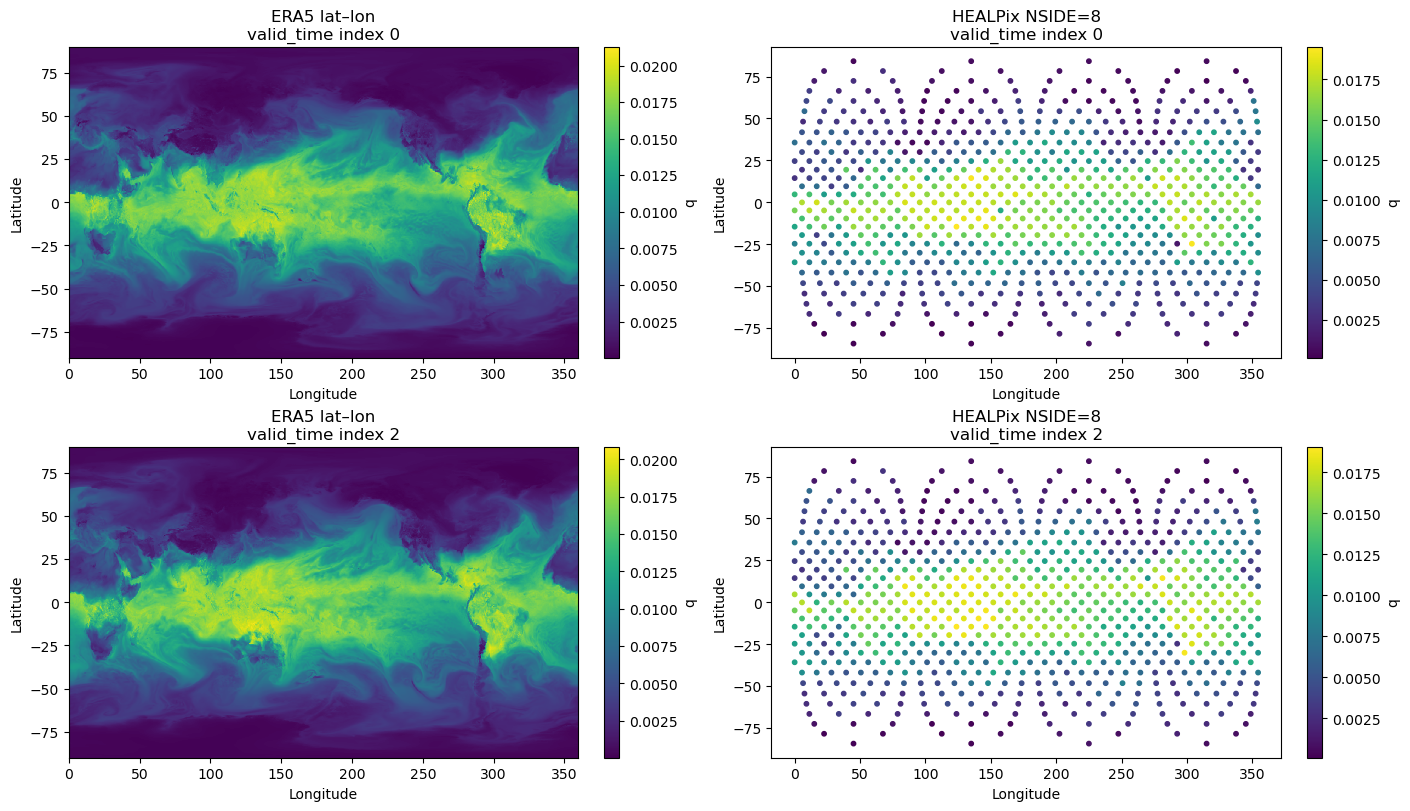

In [23]:
# STEP 34: Plot original ERA5 vs HEALPix NSIDE=8 from Zarr (2 time samples)
 
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from astropy_healpix import HEALPix
import astropy.units as u
 
# Load original + zarr
ds = xr.open_dataset("data/tmp/2024-12-01.era5.nc")
da = ds["q"]
hp8 = xr.open_zarr("data/zarr/era5_q_hp8.zarr")["q_hp8"]
 
# Choose 2 arbitrary time indices + one pressure level
level_index = 0
time_indices = [0, 2]
 
print("Selected times (original):", da.valid_time.values[time_indices])
print("Selected times (zarr):     ", hp8.valid_time.values[time_indices])
 
# HEALPix pixel coordinates
nside = 8
hp = HEALPix(nside=nside, order="ring", frame="icrs")
ipix = np.arange(hp.npix)
coords = hp.healpix_to_skycoord(ipix)
lon_hp = coords.ra.to_value(u.deg)
lat_hp = coords.dec.to_value(u.deg)
 
# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
 
for row, t in enumerate(time_indices):
    da_orig = da.isel(valid_time=t, pressure_level=level_index)
 
    im = axes[row, 0].pcolormesh(
        da_orig.longitude, da_orig.latitude, da_orig, shading="auto"
    )
    axes[row, 0].set_title(f"ERA5 lat–lon\nvalid_time index {t}")
    axes[row, 0].set_xlabel("Longitude")
    axes[row, 0].set_ylabel("Latitude")
    fig.colorbar(im, ax=axes[row, 0], label="q")
 
    da_hp = hp8.isel(valid_time=t, pressure_level=level_index)
 
    sc = axes[row, 1].scatter(lon_hp, lat_hp, c=da_hp.values, s=10)
    axes[row, 1].set_title(f"HEALPix NSIDE=8\nvalid_time index {t}")
    axes[row, 1].set_xlabel("Longitude")
    axes[row, 1].set_ylabel("Latitude")
    fig.colorbar(sc, ax=axes[row, 1], label="q")
 
plt.show()

# Visualization: ERA5 vs HEALPix Regridding
 
The figure below compares the original ERA5 specific humidity (`q`) field on the
latitude–longitude grid with the regridded HEALPix representation (NSIDE = 8).
 
Two arbitrary time samples were selected (valid_time indices 0 and 2) at the
lowest pressure level (975 hPa).

Description
 
- **Top row (ERA5 lat–lon)**  
  Specific humidity on the native ERA5 latitude–longitude grid.
  The characteristic equatorial humidity band and large-scale atmospheric
  structures are clearly visible.
 
- **Bottom row (HEALPix NSIDE = 8)**  
  The same data interpolated onto a HEALPix grid.
  Although the grid geometry changes, the large-scale spatial patterns
  are preserved, demonstrating a successful regridding operation.
 
This comparison confirms that the daily processing chain correctly:
- loads ERA5 data,
- performs HEALPix interpolation within the daily batch,
- stores and reloads the data from Zarr,
- and preserves the physical structure of the humidity field.

#### README 

## Author:
## Mohammed Fawaz Nawaz
## Matrikulation No.: 7431597
## ESDP1 WS 2025/26

# ESDP1 – Homework Assignment #2  
**Processing Chain for ERA5 Data, HEALPix Regridding, and Zarr Storage**
 
---
 
## 1. Overview
 
This homework implements a complete daily processing chain for atmospheric
reanalysis data. The workflow is able to:
 
- automatically process daily data,
- support mock downloads for testing,
- download ERA5 specific humidity data,
- regrid the data to HEALPix grids,
- store the results efficiently in Zarr format,
- reload and visualize the processed data.
 
The implementation follows the requirements of **ESDP1 WS 2025/26 – Homework #2**.
 
---
 
## 2. Dataset Description
 
- **Data source:** Copernicus Climate Data Store (ERA5 reanalysis)
- **Variable:** Specific humidity (`q`)
- **Pressure levels:** 975, 900, 800, 500, 300 hPa
- **Temporal resolution:** 6-hourly
- **Time period:** 2024-12-01 to 2024-12-05
- **Original grid:** Latitude–longitude (ERA5 native resolution)
 
---
 
## 3. Workflow Description
 
### 3.1 Daily Control Flow
 
The processing chain is organized on a **daily basis**:
 
- When the pipeline is executed **without arguments**, it automatically:
  - finds the oldest missing day,
  - processes all missing days up to the current date (or configured end date).
- When executed **with a date argument**, only the specified day is processed.
 
Processing status is tracked using `.done` marker files.
 
---
 
### 3.2 Mock Download Mode
 
To test the workflow without downloading real data, a **mock mode** is implemented.
 
Mock mode allows:
- successful downloads,
- simulated download failures,
- mixed successful/unsuccessful runs.
 
This verifies the robustness of the control flow and error handling.
 
---
 
### 3.3 ERA5 Data Download
 
For real processing, ERA5 data are downloaded using the CDS API:
 
- Flexible request definition (no hard-coded user settings inside the download routine)
- Pressure levels and variables can be easily adapted
- Data are downloaded **day-by-day** in NetCDF format
 
---
 
### 3.4 HEALPix Regridding
 
Within each daily batch, the ERA5 data are interpolated from the
latitude–longitude grid to HEALPix grids with two resolutions:
 
- **NSIDE = 8**
- **NSIDE = 16**
 
Regridding is performed **inside the daily processing chain**
(i.e. download → regrid → store).
 
---
 
### 3.5 Zarr Storage Strategy
 
Regridded data are stored in **Zarr format (v2)** to ensure compatibility.
 
#### Chunking strategy:
- `valid_time`: 1 (efficient appending of daily data)
- `pressure_level`: all levels in one chunk
- `pixel`: 512
 
New data are appended along the `valid_time` dimension when the Zarr store
already exists.
 
---
 
## 4. Visualization
 
Two arbitrary time samples (valid_time indices 0 and 2) are loaded from the Zarr
store and compared with the original ERA5 data.
 
### Interpretation:
- The original ERA5 lat–lon plots show large-scale humidity structures.
- The HEALPix plots preserve these spatial patterns despite the change in grid geometry.
- This confirms that the regridding operation is physically consistent.
 
---
 
## 5. How to Run

All commands are executed from the project root directory.

## 5.1 Mock Mode (Testing the Workflow)
The pipeline can be tested without downloading real data by enabling mock processing. This mode is useful to validate the daily control flow and error handling.
Command: python -m src.pipeline
In mock mode:
Dummy files are created instead of real downloads
Successful and failing downloads can be simulated
The pipeline correctly continues processing missing days

## 5.2 Process a Single Day (Real Data)
To process only a specific date, the date can be passed as a command-line argument.
Command: python -m src.pipeline 2024-12-01
This performs the following steps:
Downloads ERA5 data for the specified day
Regrids the data to HEALPix NSIDE=8 and NSIDE=16
Stores the regridded data in Zarr format
Marks the day as completed

## 5.3 Process All Missing Days
When the pipeline is executed without a date argument, it automatically:
identifies the oldest missing day,
processes all missing days up to the configured end date.
Command: python -m src.pipeline

## 6. Repository Structure
esdp1_hw2_clean/
src/
pipeline.py -->       (daily control flow)
config.py -->          (configuration and mock/real switches)
era5_download.py -->   (ERA5 download routines)
regrid_healpix.py -->  (latitude–longitude to HEALPix interpolation)
zarr_store.py -->      (Zarr storage and chunking strategy)
data/
tmp/ -->               (temporary ERA5 NetCDF files)
status/ -->            (daily .done marker files)
zarr/ -->              (Zarr data stores)
ESDP1_HW2.ipynb -->      (testing and visualization notebook)
README.md

## 7. Zarr Chunking Strategy
The following chunking strategy is used for storing the regridded data:
valid_time: 1
This allows efficient appending of daily data.
pressure_level: all levels in one chunk
pixel: 512
This chunking setup balances storage efficiency and data access performance and is well suited for incremental daily processing.

## 8. Results and Visualization
Two arbitrary time samples were selected from the Zarr store and compared with the original ERA5 latitude–longitude data.
The comparison shows that:
large-scale humidity structures are preserved,
the HEALPix regridding is physically consistent,
the daily processing chain works end-to-end.

## 9. Conclusion
The implemented processing chain fulfills all requirements of the assignment:
daily workflow control,
mock testing,
ERA5 data download,
HEALPix regridding (NSIDE=8 and NSIDE=16),
efficient Zarr storage with appending,
visualization of original and regridded data.
The workflow is modular, reproducible, and easily extensible to other variables or time periods.

## Author:
## Mohammed Fawaz Nawaz
## Matrikulation No.: 7431597
## ESDP1 WS 2025/26
 